In [1]:
!git clone --depth 1 https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
!bash Mecab-ko-for-Google-Colab/install_mecab-ko_on_colab190912.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 17 (delta 1), reused 13 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (17/17), 1.53 MiB | 36.35 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Installing konlpy.....
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 94.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.1/494.1 kB 29.7 MB/s eta 0:00:00
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2025-05-23 00:12:49--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 13.200.41.136, 13.200.41.134, 13.200.41.135, ...
Connecting to bitbucket.org (bitbucket.org)|13.200.41.136|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https:

In [2]:
!pip install mecab-python3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.8/588.8 kB 35.9 MB/s eta 0:00:00


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import nltk
from sklearn.model_selection import train_test_split
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from konlpy.tag import Mecab
from tqdm.notebook import tqdm
import random
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

#1.baseline

In [2]:
# 데이터 로드
train_df1 = pd.read_csv("train.csv")
train_df2 = pd.read_csv("eda_train.csv")
valid_df = pd.read_csv("valid.csv")

# 병합
train_df = pd.concat([train_df1, train_df2], ignore_index=True)

In [3]:
mecab = Mecab()

In [4]:
def preprocess(sentence):
    sentence = re.sub(r"[^a-z0-9가-힣\.!\?\s]", "", sentence)
    return mecab.morphs(sentence)

In [5]:
# df["Q_"] = df["Q"].apply(preprocess)
# df["A_"] = df["A"].apply(preprocess)
# token_leng1 = df["Q_"].apply(lambda x: len(x))
# token_leng2 = df["A_"].apply(lambda x: len(x))

# plt.figure(figsize=(14, 6))

# plt.subplot(1, 2, 1)
# plt.hist(token_leng1, bins=50, color="lightcoral", edgecolor="black")
# plt.title("question distribution")
# plt.xlabel("number of tokens")
# plt.ylabel("count")
# plt.grid(True)

# plt.subplot(1, 2, 2)
# plt.hist(token_leng2, bins=50, color="mediumseagreen", edgecolor="black")
# plt.title("answer distribution")
# plt.xlabel("number of tokens")
# plt.ylabel("count")
# plt.grid(True)

# plt.tight_layout()
# plt.show()

In [6]:
def build_corpus(df):
    df.dropna(inplace=True)
    df["Q_"] = df["Q"].apply(preprocess)
    df["A_"] = df["A"].apply(preprocess)
    df.drop_duplicates(subset=["Q_"], inplace=True)
    df.drop_duplicates(subset=["A_"], inplace=True)
    df.reset_index(drop=True, inplace=True)

    que_corpus, ans_corpus = [], []
    for i in range(len(df)):
        if len(df["Q_"][i]) < 28 and len(df["A_"][i]) < 35:
            que_corpus.append(df["Q_"][i])
            ans_corpus.append(["<SOS>"] + df["A_"][i] + ["<EOS>"])
    return que_corpus, ans_corpus

In [7]:
que_corpus_train, ans_corpus_train = build_corpus(train_df)
que_corpus_valid, ans_corpus_valid = build_corpus(valid_df)

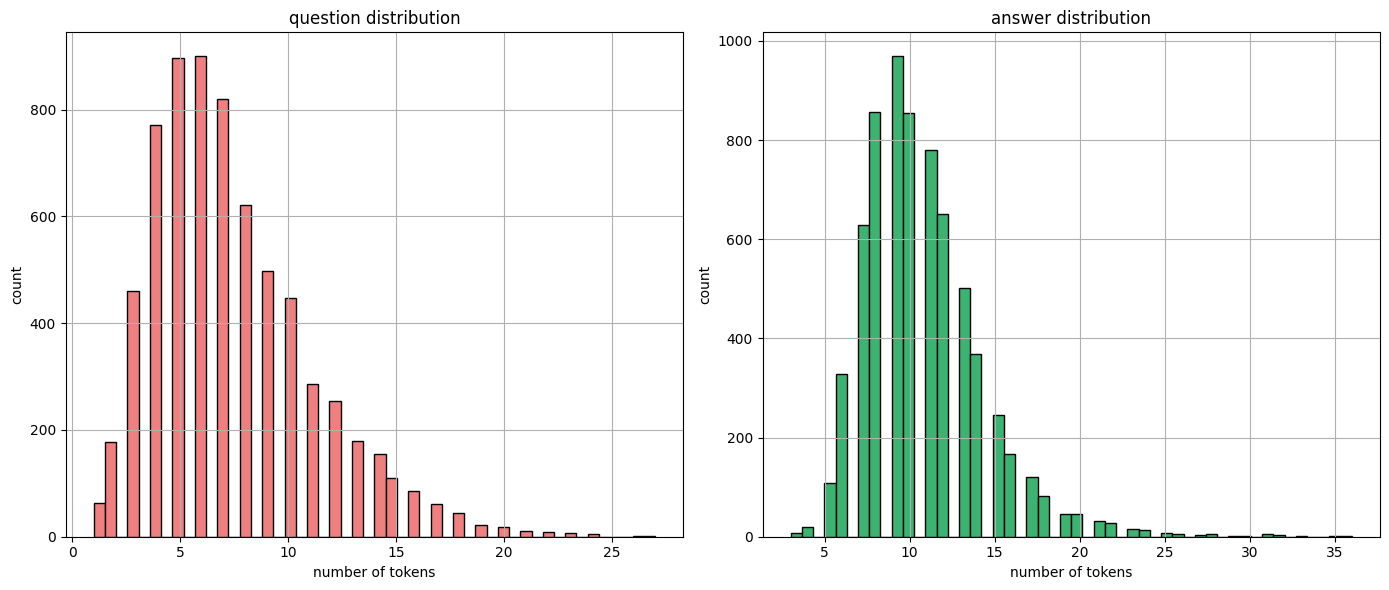

In [8]:
# 토큰 분포 시각화
token_leng1 = pd.Series(que_corpus_train).apply(lambda x: len(x))
token_leng2 = pd.Series(ans_corpus_train).apply(lambda x: len(x))

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(token_leng1, bins=50, color="lightcoral", edgecolor="black")
plt.title("question distribution")
plt.xlabel("number of tokens")
plt.ylabel("count")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(token_leng2, bins=50, color="mediumseagreen", edgecolor="black")
plt.title("answer distribution")
plt.xlabel("number of tokens")
plt.ylabel("count")
plt.grid(True)

plt.tight_layout()
plt.show()

In [9]:
def compute_vocab_coverage(corpus, topk_list=[1000, 2000, 5000, 8000, 10000, 20000]):
    tokenizer = Tokenizer(filters="", oov_token=None)
    tokenizer.fit_on_texts(corpus)

    word_counts = tokenizer.word_counts  # collections.OrderedDict
    sorted_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

    total_tokens = sum([count for _, count in sorted_counts])

    print(f"총 토큰 수: {total_tokens}")
    print(f"전체 단어 수 (고유): {len(sorted_counts)}")

    cumulative = np.cumsum([count for _, count in sorted_counts])
    coverage_list = [
        cumulative[k - 1] / total_tokens * 100 if k <= len(cumulative) else 100.0
        for k in topk_list
    ]

    for k, cov in zip(topk_list, coverage_list):
        print(f"Vocab Size = {k:5d} → Coverage: {cov:.2f}%")

    plt.figure(figsize=(8, 4))
    plt.plot(np.arange(1, len(cumulative) + 1), cumulative / total_tokens * 100)
    plt.xlabel("Vocab Size (Top-N Words)")
    plt.ylabel("Coverage (%)")
    plt.title("Vocab Size vs. Token Coverage")
    plt.grid(True)
    plt.axhline(95, color="r", linestyle="--", label="95% Cutoff")
    plt.legend()
    plt.tight_layout()
    plt.show()

총 토큰 수: 125408
전체 단어 수 (고유): 5944
Vocab Size =  1000 → Coverage: 91.17%
Vocab Size =  2000 → Coverage: 95.49%
Vocab Size =  5000 → Coverage: 99.25%
Vocab Size =  8000 → Coverage: 100.00%
Vocab Size = 10000 → Coverage: 100.00%
Vocab Size = 20000 → Coverage: 100.00%


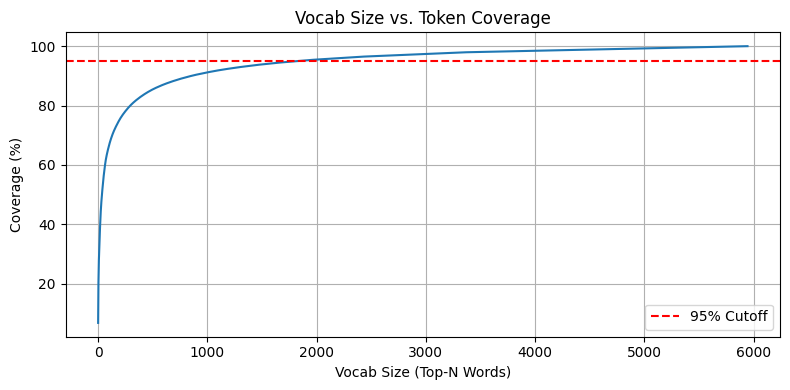

In [10]:
# 학습 코퍼스 기준 커버리지 확인
compute_vocab_coverage(que_corpus_train + ans_corpus_train)

In [11]:
def tokenize(corpus1, corpus2, vocab_size=None, oov_token="<OOV>"):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size, filters="")
    tokenizer.fit_on_texts(corpus1 + corpus2)

    tensor1 = tokenizer.texts_to_sequences(corpus1)
    tensor2 = tokenizer.texts_to_sequences(corpus2)

    tensor1 = tf.keras.preprocessing.sequence.pad_sequences(tensor1, padding="post")
    tensor2 = tf.keras.preprocessing.sequence.pad_sequences(tensor2, padding="post")

    return tensor1, tensor2, tokenizer

In [12]:
enc_corpus, dec_corpus, tokenizer = tokenize(que_corpus_train, ans_corpus_train)

In [13]:
def tokenize_with_existing_tokenizer(corpus1, corpus2, tokenizer):
    tensor1 = tokenizer.texts_to_sequences(corpus1)
    tensor2 = tokenizer.texts_to_sequences(corpus2)

    tensor1 = tf.keras.preprocessing.sequence.pad_sequences(tensor1, padding="post")
    tensor2 = tf.keras.preprocessing.sequence.pad_sequences(tensor2, padding="post")

    return tensor1, tensor2

enc_valid, dec_valid = tokenize_with_existing_tokenizer(que_corpus_valid, ans_corpus_valid, tokenizer)

# tf.data.Dataset 구성
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = tf.data.Dataset.from_tensor_slices((enc_corpus, dec_corpus))
train_dataset = train_dataset.shuffle(len(enc_corpus)).batch(BATCH_SIZE).prefetch(AUTOTUNE)

valid_dataset = tf.data.Dataset.from_tensor_slices((enc_valid, dec_valid))
valid_dataset = valid_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [14]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, (2 * (i // 2)) / np.float32(d_model))

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table


def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]


def generate_lookahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask


def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_enc_mask = generate_padding_mask(src)

    dec_lookahead_mask = generate_lookahead_mask(tgt.shape[1])
    dec_tgt_padding_mask = generate_padding_mask(tgt)
    dec_mask = tf.maximum(dec_tgt_padding_mask, dec_lookahead_mask)

    return enc_mask, dec_enc_mask, dec_mask


# Multi Head Attention 구현
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        self.depth = d_model // self.num_heads

        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)

        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None:
            scaled_qk += mask * -1e9

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions

    def split_heads(self, x):
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))

        return combined_x

    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)

        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)

        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask
        )

        out = self.combine_heads(out)
        out = self.linear(out)

        return out, attention_weights


class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        self.fc1 = tf.keras.layers.Dense(d_ff, activation="relu")
        self.fc2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.fc1(x)
        out = self.fc2(out)

        return out


class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, mask):
        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual

        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, enc_attn


class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.do(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        # Q, K, V 순서에 주의하세요!
        out, dec_enc_attn = self.enc_dec_attn(
            Q=out, K=enc_out, V=enc_out, mask=dec_enc_mask
        )
        out = self.do(out)
        out += residual

        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn


class Encoder(tf.keras.Model):
    def __init__(self, n_layers, d_model, n_heads, d_ff, dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [
            EncoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)
        ]

        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, mask):
        out = x

        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)

        return out, enc_attns


class Decoder(tf.keras.Model):
    def __init__(self, n_layers, d_model, n_heads, d_ff, dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [
            DecoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)
        ]

    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        out = x

        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = self.dec_layers[i](
                out, enc_out, dec_enc_mask, padding_mask
            )

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns


class Transformer(tf.keras.Model):
    def __init__(
        self,
        n_layers,
        d_model,
        n_heads,
        d_ff,
        src_vocab_size,
        tgt_vocab_size,
        pos_len,
        dropout=0.2,
        shared_fc=True,
        shared_emb=False,
    ):
        super(Transformer, self).__init__()

        self.d_model = tf.cast(d_model, tf.float32)

        if shared_emb:
            self.enc_emb = self.dec_emb = tf.keras.layers.Embedding(
                src_vocab_size, d_model
            )
        else:
            self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
            self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared_fc = shared_fc

        if shared_fc:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]

        out = emb(x)

        if self.shared_fc:
            out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out

    def call(self, enc_in, dec_in, enc_mask, dec_enc_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)

        dec_out, dec_attns, dec_enc_attns = self.decoder(
            dec_in, enc_out, dec_enc_mask, dec_mask
        )

        logits = self.fc(dec_out)

        return logits, enc_attns, dec_attns, dec_enc_attns

In [15]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()

        self.d_model = d_model
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = step**-0.5
        arg2 = step * (self.warmup_steps**-1.5)

        return (self.d_model**-0.5) * tf.math.minimum(arg1, arg2)

In [16]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction="none"
)


def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_) / tf.reduce_sum(mask)

In [17]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    tgt_in = tgt[:, :-1]  # Decoder의 input
    gold = tgt[
        :, 1:
    ]  # Decoder의 output과 비교하기 위해 right shift를 통해 생성한 최종 타겟

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = model(
            src, tgt_in, enc_mask, dec_enc_mask, dec_mask
        )
        loss = loss_function(gold, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

In [18]:
@tf.function
def eval_step(src, tgt, model):
    tgt_in = tgt[:, :-1]
    gold = tgt[:, 1:]

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    predictions, enc_attns, dec_attns, dec_enc_attns = model(
        src, tgt_in, enc_mask, dec_enc_mask, dec_mask
    )

    loss = loss_function(gold, predictions)

    return loss, enc_attns, dec_attns, dec_enc_attns

In [19]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best = None
        self.wait = 0
        self.stopped_epoch = 0
        self.stop_training = False

    def on_epoch_end(self, epoch, current):
        if self.best is None or current < self.best - self.min_delta:
            self.best = current
            self.wait = 0
            return True
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stop_training = True
                self.stopped_epoch = epoch
            return False

In [20]:
def plot_loss_graph(train_log, test_log):
    epochs = range(1, len(train_log) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_log, label="Train Loss")
    plt.plot(epochs, test_log, label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train/Test Loss per Epoch")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [21]:
def greedy_decode(model, tokenizer, input_text, max_length=35, sos_id=None, eos_id=None):
    """
    Greedy decoding을 사용하여 입력 텍스트에 대한 응답을 생성합니다.

    Args:
        model: 학습된 Transformer 모델
        tokenizer: 텍스트 토크나이저
        input_text: 입력 텍스트 (문자열)
        max_length: 생성할 최대 시퀀스 길이
        sos_id: Start of Sequence 토큰 ID (기본값: "< SOS >" 토큰 찾기)
        eos_id: End of Sequence 토큰 ID (기본값: "<EOS>" 토큰 찾기)

    Returns:
        str: 생성된 응답 텍스트
    """
    # SOS, EOS 토큰 ID 찾기
    if sos_id is None:
        sos_id = tokenizer.word_index.get("< SOS >", tokenizer.word_index.get("<SOS>", 2))
    if eos_id is None:
        eos_id = tokenizer.word_index.get("<EOS>", 3)

    # 입력 텍스트 전처리 및 토크나이징
    if isinstance(input_text, str):
        # 문자열인 경우 mecab으로 형태소 분석
        processed_input = preprocess(input_text)
        input_sequence = tokenizer.texts_to_sequences([processed_input])
    else:
        # 이미 리스트인 경우
        input_sequence = tokenizer.texts_to_sequences([input_text])

    # 패딩 적용
    input_sequence = tf.keras.preprocessing.sequence.pad_sequences(
        input_sequence, padding='post'
    )

    # 배치 차원 추가 및 int32 타입으로 변환
    encoder_input = tf.convert_to_tensor(input_sequence, dtype=tf.int32)

    # 디코더 입력 초기화 (SOS 토큰으로 시작, int32 타입)
    decoder_input = tf.convert_to_tensor([[sos_id]], dtype=tf.int32)

    # 생성 루프
    for i in range(max_length):
        # 마스크 생성
        enc_mask, dec_enc_mask, dec_mask = generate_masks(encoder_input, decoder_input)

        # 모델 예측
        predictions, _, _, _ = model(
            encoder_input, decoder_input, enc_mask, dec_enc_mask, dec_mask
        )

        # 마지막 토큰의 예측값에서 가장 높은 확률의 토큰 선택
        predicted_id = tf.argmax(predictions[:, -1:, :], axis=-1)

        # int32로 타입 변환 (concat 오류 방지)
        predicted_id = tf.cast(predicted_id, tf.int32)

        # EOS 토큰이 생성되면 종료
        if predicted_id.numpy()[0, 0] == eos_id:
            break

        # 디코더 입력에 예측된 토큰 추가
        decoder_input = tf.concat([decoder_input, predicted_id], axis=-1)

    # 생성된 시퀀스를 텍스트로 변환
    generated_sequence = decoder_input.numpy()[0]

    # SOS, EOS 토큰 제거 및 텍스트 변환
    generated_tokens = []
    for token_id in generated_sequence[1:]:  # SOS 토큰 제외
        if token_id == eos_id or token_id == 0:  # EOS 또는 패딩 토큰이면 종료
            break
        if token_id in tokenizer.index_word:
            generated_tokens.append(tokenizer.index_word[token_id])

    return ' '.join(generated_tokens)


# 사용 예시 함수
def generate_response(model, tokenizer, question):
    """
    질문에 대한 응답을 생성하는 편의 함수

    Args:
        model: 학습된 Transformer 모델
        tokenizer: 텍스트 토크나이저
        question: 질문 문자열

    Returns:
        str: 생성된 응답
    """
    return greedy_decode(model, tokenizer, question)


# 배치 처리를 위한 함수
def greedy_decode_batch(model, tokenizer, input_texts, max_length=35, sos_id=None, eos_id=None):
    """
    여러 입력에 대해 배치 처리로 greedy decoding 수행

    Args:
        model: 학습된 Transformer 모델
        tokenizer: 텍스트 토크나이저
        input_texts: 입력 텍스트 리스트
        max_length: 생성할 최대 시퀀스 길이
        sos_id: Start of Sequence 토큰 ID
        eos_id: End of Sequence 토큰 ID

    Returns:
        list: 생성된 응답 텍스트 리스트
    """
    responses = []
    for text in input_texts:
        response = greedy_decode(model, tokenizer, text, max_length, sos_id, eos_id)
        responses.append(response)
    return responses

In [22]:
from nltk.translate.bleu_score import sentence_bleu

def compute_bleu_score(reference_texts, generated_texts):
    scores = []
    for ref, gen in zip(reference_texts, generated_texts):
        ref_tokens = ref.split()
        gen_tokens = gen.split()
        score = sentence_bleu([ref_tokens], gen_tokens, weights=(0.5, 0.5))
        scores.append(score)
    return sum(scores) / len(scores) if scores else 0

In [23]:
def ids_to_text(tokenizer, ids, pad_id=0):
    return ' '.join([tokenizer.index_word.get(i, '') for i in ids if i != 0 and i != pad_id])

def compute_bleu_from_validation(model, tokenizer, dataset, num_samples=10, sos_id=2, eos_id=3, pad_id=0):
    references = []
    predictions = []
    count = 0

    for src_batch, tgt_batch in dataset:
        for src, tgt in zip(src_batch.numpy(), tgt_batch.numpy()):
            if count >= num_samples:
                break

            src_text = ids_to_text(tokenizer, src)
            tgt_text = ids_to_text(tokenizer, tgt[1:])  # <sos> 제외

            pred_text = greedy_decode(model, tokenizer, src_text, sos_id=sos_id, eos_id=eos_id)

            references.append(tgt_text)
            predictions.append(pred_text)

            count += 1

        if count >= num_samples:
            break

    return compute_bleu_score(references, predictions)

In [24]:
def main(
    transformer,
    optimizer,
    name,
    EPOCHS=10,
    early_stopping=EarlyStopping(patience=3, min_delta=0.001),
    train_dataset=train_dataset,
    valid_dataset=valid_dataset,
    save=True,
):
    train_log = []
    valid_log = []

    for epoch in range(EPOCHS):
        total_loss = 0
        dataset_count = tf.data.experimental.cardinality(train_dataset).numpy()
        tqdm_bar = tqdm(total=dataset_count)

        for batch, (src, tgt) in enumerate(train_dataset):
            loss, _, _, _ = train_step(src, tgt, transformer, optimizer)
            total_loss += loss
            tqdm_bar.set_description(f"Epoch {epoch + 1}")
            tqdm_bar.set_postfix(loss=total_loss.numpy() / (batch + 1))
            tqdm_bar.update(1)

        tqdm_bar.close()
        train_epoch_loss = total_loss.numpy() / dataset_count
        train_log.append(train_epoch_loss)

        val_loss_total = 0
        val_batches = tf.data.experimental.cardinality(valid_dataset).numpy()

        for batch, (src, tgt) in enumerate(valid_dataset):
            loss, _, _, _ = eval_step(src, tgt, transformer)
            val_loss_total += loss

        val_epoch_loss = val_loss_total.numpy() / val_batches
        valid_log.append(val_epoch_loss)

        # BLEU 계산
        bleu_score = compute_bleu_from_validation(transformer, tokenizer, valid_dataset, num_samples=10)

        # 🔸 수정된 출력 라인: train loss, val loss, BLEU 모두 출력
        print(f"[Epoch {epoch + 1}] Train Loss: {train_epoch_loss:.4f} | Val Loss: {val_epoch_loss:.4f} | BLEU: {bleu_score:.4f}")

        is_best = early_stopping.on_epoch_end(epoch, val_epoch_loss)
        if save and is_best:
            transformer.save_weights(name + "best_model.weights.h5")
            print(f"Best model saved at epoch {epoch+1}")

        if early_stopping.stop_training:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    plot_loss_graph(train_log, valid_log)

    if save:
        transformer.load_weights(name + "best_model.weights.h5")

    return transformer, train_log, valid_log


---

In [25]:
import tensorflow.keras.backend as K

K.clear_session()

In [26]:
transformer1 = Transformer(
    n_layers=1,
    d_model=368,
    n_heads=8,
    d_ff=1024,
    src_vocab_size=len(tokenizer.word_index) + 1,
    tgt_vocab_size=len(tokenizer.word_index) + 1,
    pos_len=80,
    dropout=0.2,
    shared_fc=True,
    shared_emb=True,
)

d_model = 512

In [27]:
learning_rate = LearningRateScheduler(d_model, warmup_steps=1000)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9
)

early_stopping = EarlyStopping(patience=4, min_delta=0.001)

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch 1] Train Loss: 6.1386 | Val Loss: 4.4381 | BLEU: 0.0379
Best model saved at epoch 1


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch 2] Train Loss: 4.0455 | Val Loss: 3.6866 | BLEU: 0.0000
Best model saved at epoch 2


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch 3] Train Loss: 3.2938 | Val Loss: 3.4638 | BLEU: 0.1067
Best model saved at epoch 3


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch 4] Train Loss: 2.6145 | Val Loss: 3.5130 | BLEU: 0.0320


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch 5] Train Loss: 1.9082 | Val Loss: 3.8239 | BLEU: 0.0189


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch 6] Train Loss: 1.3590 | Val Loss: 4.1620 | BLEU: 0.0364


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch 7] Train Loss: 1.1550 | Val Loss: 4.4685 | BLEU: 0.0452
Early stopping triggered at epoch 7


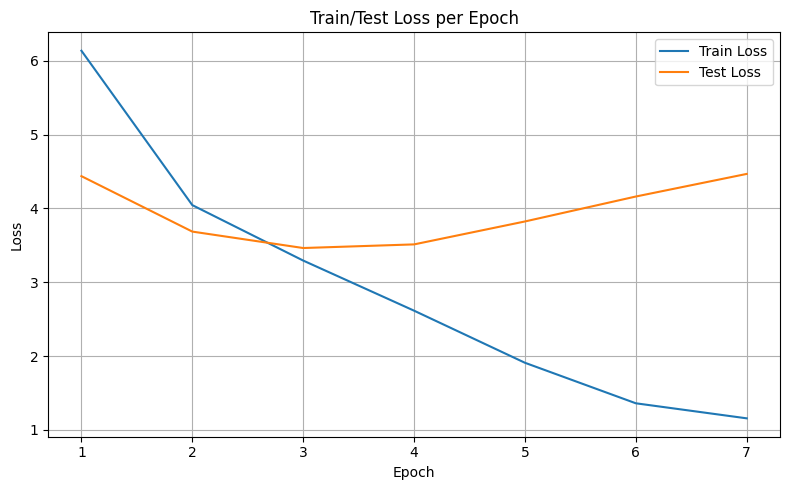

In [28]:
transformer1, train_log, valid_log = main(
    transformer1,
    optimizer,
    "transformer1_",
    EPOCHS=10,
    early_stopping=early_stopping,
    train_dataset=train_dataset,
    valid_dataset=valid_dataset,
)

In [29]:
import torch
import math
from transformers import AutoTokenizer, AutoModelForCausalLM

def generate_answer(model, tokenizer, question, device, max_length=50):
    # 질문과 답변 시작 토큰 조합
    prompt = f"질문: {question}\n답변: "
    inputs = tokenizer(prompt, return_tensors='pt').to(device)
    output_ids = model.generate(
        **inputs,
        max_length=inputs['input_ids'].size(1) + max_length,
        pad_token_id=tokenizer.eos_token_id,
        do_sample=True,  # 샘플링으로 다양성 증가 가능
        top_p=0.9,
        top_k=50,
        temperature=0.8
    )
    generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    # 답변 부분만 추출 (질문 다음부터)
    answer = generated_text.split("답변:")[-1].strip()
    return answer

def calculate_perplexity_for_answer(model, tokenizer, question, answer, device):
    conversation = f"질문: {question}\n답변: {answer}"

    inputs = tokenizer(conversation, return_tensors='pt', padding=True).to(device)

    question_part = f"질문: {question}\n답변: "
    question_inputs = tokenizer(question_part, return_tensors='pt')
    question_length = question_inputs['input_ids'].size(1)

    with torch.no_grad():
        outputs = model(inputs['input_ids'], attention_mask=inputs['attention_mask'], labels=inputs['input_ids'])

        shift_logits = outputs.logits[..., :-1, :].contiguous()
        shift_labels = inputs['input_ids'][..., 1:].contiguous()

        answer_mask = torch.zeros_like(shift_labels, dtype=torch.bool)
        answer_mask[:, question_length-1:] = True

        loss_fct = torch.nn.CrossEntropyLoss(reduction='none')
        losses = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
        losses = losses.view(shift_labels.shape)

        masked_losses = losses * answer_mask.float()
        answer_loss = masked_losses.sum() / answer_mask.sum()

    return math.exp(answer_loss.item())



device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
model.eval()

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

qa_pairs = [
    ("지루하다, 놀러가고 싶어.", "그럴 땐 가볍게 산책이라도 나가보는 건 어때요? 기분 전환에 좋을 거예요!"),
    ("오늘 일찍 일어났더니 피곤하다.", "수고 많았네요! 잠깐 눈이라도 붙이면 좀 나아질 거예요."),
    ("간만에 여자친구랑 데이트 하기로 했어.", "좋은 시간 보내세요! 어디 가실 건가요?"),
    ("집에 있는다는 소리야.", "그럼 집에서 푹 쉬거나 좋아하는 거 하면서 힐링해보세요!")
]

print("=== 생성 답변 및 개별 Perplexity 출력 ===")
for question, ground_truth in qa_pairs:
    generated_answer = generate_answer(model, tokenizer, question, device)
    ppl = calculate_perplexity_for_answer(model, tokenizer, question, generated_answer, device)
    print(f"질문: {question}")
    print(f"생성 답변: {generated_answer}")
    print(f"생성 답변 Perplexity: {ppl:.2f}")
    print('-' * 40)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


=== 생성 답변 및 개별 Perplexity 출력 ===


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


질문: 지루하다, 놀러가고 싶어.
생성 답변: 과제과, 저연는 네무리기고 지는부게으�
생성 답변 Perplexity: 6.24
----------------------------------------
질문: 오늘 일찍 일어났더니 피곤하다.
생성 답변: 가사질다가 지를 실늘 게지를 수는니다. 신�
생성 답변 Perplexity: 5.78
----------------------------------------
질문: 간만에 여자친구랑 데이트 하기로 했어.
생성 답변: 것만에 여자친구랑 데이트 하기로 했어.
생성 답변 Perplexity: 1.32
----------------------------------------
질문: 집에 있는다는 소리야.
생성 답변: 트무에 있는다는 소리야지 들에 있는다는 �
생성 답변 Perplexity: 2.54
----------------------------------------


# 회고
- eda 증강을 했는데 미숙한 탓에 단어가 잘려서 나왔다. 하지만 시간이 부족해서 그대로 진행했다. + 유의어 대체가 되지 않았다.
- 그 결과 답변 생성이 아예 해석할 수 없게 나왔다. 아무래도 앞서 말한 단어가 잘린 증강 데이터들 문제인 것 같다.
- eda 증강을 시도하려면 랜덤 삭제에서는 조사만 삭제하거나, 삽입에서는 명사와 서술어를 추가하거나 그런 식으로 진행해야 될 것 같다.
